# ML : Tag classification

For this last part we wanted to do some Multilabel classification of the tags based on the text of each questions.
The constraint was to use :
1. `pyspark.ml` library
2. `pyspark.mllib` library
3. A third party library in a spark pipeline

We have been disapointed to learn that pyspark ml and mllib had multi label classification implementation for its algorithm.
Indeed those one can do multi class classification but not multi label. A way to go by this issue would have been to use a string indexer to transform our multlabel into problem one :
Example: if we have three classes $A,B,C$, the stringindexer creates new classes $AB,BC,AC,ABC$, so the model just becomes single label multiclass pb..
There are several problem this method : 
- Dimensionnality : we have a lot more than three tags in the sample. It would have been tramendous computations for really poor results
- A tramendous loose of in information, we would a have lost a part of the label correlation.

After some computation expensive non concluent tests we decided that we will do only multiclass classification on the 10 most used tags (which is often the language associated to the post as we already noticed).


We deciced to only use **20%** of our sample (approx 400 000 rows). Indeed we suffered of of memory overload while fitting our models. 

#### Imports

In [1]:
import os
os.chdir(os.environ['HOME'])

import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType, ArrayType,IntegerType, FloatType
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

import pyspark
import sparknlp
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.types import LongType, StringType
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.feature as sf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

seed = 2020

In [2]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

In [3]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

### Clean the data
We use a similar Pipeline that for our feature/target analysis in order to perform ML on it. It was a choice of us to not put it into a module and call it to be clearer on the steps we have done. 
It is also a choice that we do not include those steps in the ML since they are computionnaly costly and unlikely to changed. 

#### Reads the data

In [ ]:
%%time
post_dir = "Data/sample/Posts"
posts = (sqlcontext
         .read
         .format("parquet")
         .option("header",True)
         .load(post_dir)
         .sample(False, 0.2, seed)
         .select("Id",
                  F.concat_ws(' ',F.col('Title'),F.col('Body')).alias("full_text"),
                  "Tags"
                )
        )

#### Splits tags

In [ ]:
tags_split =tags_split = F.regexp_replace( F.regexp_replace(
    F.regexp_replace(F.col('Tags'), '&lt;', ''), "&gt;", "<split_token>"), " ", "")

udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1]) if isinstance(x,list) else None,StringType())

posts = (
    posts
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"), "<split_token>"))
    .withColumn('Splitted_tags', udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),","))
    .drop('Tags')
)

#### Clean text

In [ ]:
input_col = "full_text"
clean_up_patterns = [
                    "p&gt;"
                    ,"&.*?;\space"
                    ,'&.*?;'                
                    ,"/.*?;"
                    ,"/code"
                    ,"/pre"
                    ,'/p'
                    ,"/a"
                    ,"href="
                    ,"lt;"
                    ,"gt;"
                    ,"[^\w\s]"
                    ,r"\b\d+\b"
                  ]


# Document assembler : Tokenize our text
documentAssembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol('_intermediate_results')

# Document normalizer : Normalize the document
# by lowercasing, removing non utf8 chars
# and remove regex oattern defined
doc_norm = DocumentNormalizer() \
    .setInputCols("_intermediate_results") \
    .setOutputCol(input_col + "_cleaned") \
    .setAction("clean") \
    .setPatterns(clean_up_patterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

# Document tokenizer : allows to remove
# undesired tokens (punctuations etc.)
# prepare the colums for the stopwords 
# remover
tokenizer = Tokenizer() \
    .setInputCols([input_col + "_cleaned"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) \
    .setSplitPattern("'") \
    .setMaxLength(0) \
    .setMaxLength(99999) \
    .setCaseSensitiveExceptions(False)


# StopWordsCleaner : remove 
# the stopwords based on
# a predifined list
Stop_words_cleaner = (
    StopWordsCleaner()
    .pretrained("stopwords_en", "en")
    .setInputCols(["token"])
    .setOutputCol(input_col + "_without_stopwords") 
    .setCaseSensitive(False) 
    .setLazyAnnotator(False)
)

# Lemmatize the text 
# thanks to the lemmatizing tab
# defined above
Lemmatizer_cleaner = (
    Lemmatizer() 
    .setInputCols([input_col + "_without_stopwords"]) 
    .setOutputCol(input_col + "_lemmatized") 
    .setDictionary("./Data/lemmatizer/AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->") 
    .setLazyAnnotator(False)
)


# Creates thepipeline
cleaning_pipeline = (
    Pipeline() 
    .setStages([
        documentAssembler,
        doc_norm,
        tokenizer,
        #Document_cleaner,
        Stop_words_cleaner,
        Lemmatizer_cleaner])
)


posts_ml = (
    cleaning_pipeline
    .fit(posts)
    .transform(posts)
    .select(F.col("Id"),
            F.col(input_col),
            F.col(input_col + "_lemmatized.result"),
            F.col("Splitted_tags")
           )
) 


#### Choose only the 10 most used tags and create a label column

In [ ]:
top = 10
tags = (posts_ml
        .select(F.explode('Splitted_tags').alias("tags"))
        .select(F.trim("tags").alias("tags"))
        .groupBy('tags')
        .count()
       ).toPandas()

top = 10
top10 = tags.sort_values(by ="count",ascending = False).head(top).tags.tolist()

posts_ml = (
    posts_ml
    .withColumn('language_deduced',
                data_transfo.udf_detect_language(top10)(F.col('Splitted_tags'))))

#### Creates our final set and save the training set for our scripts

In [ ]:
posts_multi_class = (posts_ml
                     .select(F.col('result').alias("text"),
                            data_transfo.udf_detect_language(top10)(F.col('Splitted_tags')).alias("first_label"))
                     .where(F.col('first_label').isNotNull())
                    )

In [ ]:
path_to_data = "train/training_sample"
train_split, test_split = posts_multi_class.randomSplit(weights=[0.80, 0.20], seed=seed)
if not os.path.exists(path_to_data): 
    train_split.write.parquet(path_to_data)

###  `pyspark.ml` pipeline 

In the train folder you will find a a script named `train_lr.py` this scripts creates a `pyspark.ml` composed of a : 
- A tf transformer
- An idf transformer
- A label encoder 
- A regularized logistic regression

On this pipeline we test with a grid search (on 4 fold cross validation) the following parameters : 
- "TF IDF Vocabulary size" : [10, 100, 1000, 1500] 
- "Logistic regression L2 penalization : " [0.1, 0.01, 0.001]

We take the best score according to the F1 weighted measure among class.
All the fitted pipeline has been saved in `/train/models/ml_lr.pk`

You can run (if you have time to loose) this module using the jupyter command line (**be aware that it is  memory expensive**).
```shell
cd train
python3 -m train_lr
```

**We will analyze the result of this pipeline on the test set**

In [4]:
path_to_data = "train/training_sample"
training_set = (sqlcontext
                 .read
                 .format("parquet")
                 .option("header",True)
                 .load(path_to_data)
                 .sample(0.01)
                )

In [9]:
training_set.cache().count()

1669

In [12]:
features = "text"
label = "first_label"

# TF
cv = sf.CountVectorizer(inputCol=features, outputCol="tf_features")

# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")

# StringIndexer 
label_string= sf.StringIndexer(inputCol=label, outputCol ="label")

# Logistic regression
lr = LogisticRegression(maxIter=10,family="multinomial")
pipeline = Pipeline(stages=[cv, idf, label_string, lr])
paramGrid = (ParamGridBuilder() 
             .addGrid(cv.vocabSize, [10, 100, 1000, 5000]) 
             .addGrid(lr.regParam, [0.1, 0.01, 0.001]) 
             .build()
            )

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training_set)


In [13]:
best_model = cvModel.bestModel
best_model.write().overwrite().save('train/models/lr/lol')

In [7]:
a = PipelineModel.load('train/train/models/lr/ml_lr')

In [29]:
a.transform(training_set)

DataFrame[text: array<string>, first_label: string, tf_features: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [14]:
import pandas as pd

def get_cv_results(crossval_model):
    """
    Returns a dataframe with the tested parameters
    """
    params = [{p.name: v for p, v in m.items()} for m in crossval_model.getEstimatorParamMaps()]

    results = pd.DataFrame.from_dict([
        {crossval_model.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, crossval_model.avgMetrics)
    ])
    return results

def evaluation_metrics(predictionAndLabels, labels):
    """
    Computes the multiclass metrics for predictions and labels 
    args:
        predictionAndLabels: And RDD composed of (prediction, label)
        labels: A list of the unique labels to predict
    returns:
        metrics_results(df) : The multi class metrics by labels
        global_metrics(dict) : The global metrics 
        confusion_matrix (df): The confusion Matrix
    """

    metrics = MulticlassMetrics(predictionAndLabels)

    results = []
    # Statistics by class
    
    for label in sorted(labels):
        results.append((label, metrics.precision(label),metrics.recall(label), metrics.fMeasure(label, beta=1.0)))
    metrics_results = pd.DataFrame(results, columns = ['Label', "Precision","Recall","F1"])

    # Weighted stats
    global_metrics = {}
    global_metrics["weightedRecall"] = metrics.weightedRecall
    global_metrics["weightedPrecision"] = metrics.weightedPrecision
    global_metrics["weightedFMeasure"] = metrics.weightedFMeasure()
    global_metrics["weightedFPR"] = metrics.weightedFalsePositiveRate
    
    # Confusion Matrix
    confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray(), columns = labels, index=labels)
    return metrics_results, global_metrics, confusion_matrix


get_cv_results(cvModel)

,f1,vocabSize,regParam
0,0.218638,10,0.100
1,0.251920,10,0.010
2,0.274273,10,0.001
3,0.469281,100,0.100
4,0.543292,100,0.010
5,0.558407,100,0.001
6,0.646479,1000,0.100
7,0.672130,1000,0.010
8,0.678493,1000,0.001
9,0.660200,5000,0.100


In [15]:
from pyspark.mllib.evaluation import MulticlassMetrics
preds_test = cvModel.transform(test_split)

# Compute raw scores on the test set
predictionAndLabels = preds_test.rdd.map(lambda lp: (float(lp.prediction), lp.label))
labels = preds_test.rdd.map(lambda lp: lp.label).distinct().collect()


metrics_results, global_metrics, confusion_matrix = evaluation_metrics(predictionAndLabels, labels)

# Put it into list:
label_string.fit(test_split).transform(test_split).select(label, "label").distinct().toPandas().to_dict()

{'first_label': {0: 'php',
  1: 'javascript',
  2: 'css',
  3: 'jquery',
  4: 'python',
  5: 'html',
  6: 'java',
  7: 'c++',
  8: 'c#',
  9: 'android'},
 'label': {0: 4.0,
  1: 0.0,
  2: 9.0,
  3: 8.0,
  4: 1.0,
  5: 7.0,
  6: 2.0,
  7: 6.0,
  8: 3.0,
  9: 5.0}}

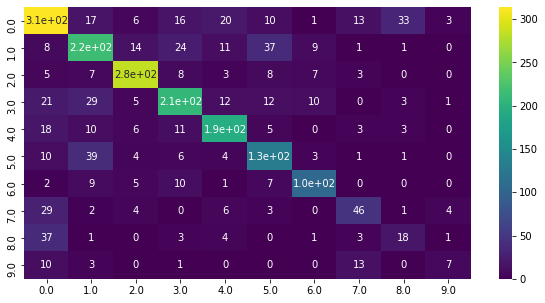

In [16]:
# add confusion matrix from pd.crosstab earlier
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix,annot=True,cmap="viridis");

In [17]:
1

1

In [18]:
posts_multi_class.show()

+--------------------+-----------+
|                text|first_label|
+--------------------+-----------+
|[value, key, nest...|       java|
|[trigger, click, ...| javascript|
|[encode, php, doc...|        php|
|[android, fragmen...|    android|
|[pair, row, conso...|     python|
|[ensure, checkbox...| javascript|
|[error, compile, ...|    android|
|[save, data, loca...| javascript|
|[simplexml_load_s...|        php|
|[tag, gtm, body, ...|        php|
|[winappdriver, cl...|     python|
|[open, call, acti...|    android|
|[limit, display, ...| javascript|
|[access, chainway...|       java|
|[argument, pass, ...|        php|
|[merge, column, n...|     python|
|[onedit, timestam...| javascript|
|[run, docker, com...|         c#|
|[step, epoch, doe...|     python|
|[switch, empty, d...|        c++|
+--------------------+-----------+
only showing top 20 rows



In [19]:
from elephas.spark_model import SparkModel
from pyspark.mllib.feature import HashingTF, IDF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from pyspark.mllib.feature import HashingTF, IDF

In [20]:
posts_multi_class

DataFrame[text: array<string>, first_label: string]

In [21]:
top

10

In [9]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors

input_dim = 100
output_dim = 10

# TF
cv = sf.CountVectorizer(inputCol="text", outputCol="tf_features",vocabSize=100)
# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")
label_string= sf.StringIndexer(inputCol="first_label", outputCol ="label")
pipeline_dl = Pipeline(stages=[cv, idf, label_string])
df = pipeline_dl.fit(training_set).transform(training_set)
df = df.rdd.map(lambda x :( LabeledPoint(x['label'],MLLibVectors.fromML(x['features']))))

In [10]:
df

PythonRDD[68] at RDD at PythonRDD.scala:53

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_keras_model():
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model
model = create_keras_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [97]:
from pyspark.mllib.evaluation import MulticlassMetrics
from elephas.spark_model import SparkMLlibModel,load_spark_model

spark_model = SparkMLlibModel(model=model, frequency='epoch', mode='asynchronous',parameter_server_mode='socket')
spark_model.fit(df, epochs=2, batch_size=32, verbose=1,validation_split=0.1, categorical=True, nb_classes=output_dim)

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/loic/.local/lib/python3.6/site-packages/elephas/parameter/server.py", line 177, in start_server
    sock.bind((host, self.port))
OSError: [Errno 98] Address already in use



>>> Initialize workers
>>> Distribute load
>>> Async training complete.


In [101]:
spark_model._master_network.save("train/models/nn")

INFO:tensorflow:Assets written to: train/models/nn/assets


In [43]:
from elephas.spark_model import SparkMLlibModel,load_spark_model

In [67]:
spark_model.predict(df.collect())

AttributeError: 'list' object has no attribute '__name__'

In [73]:
spark_model._master_network.save("og")

INFO:tensorflow:Assets written to: og/assets


In [76]:
from tensorflow.keras import models
aa = models.load_model("og")


In [77]:
bb = SparkMLlibModel(model=aa, frequency='epoch', mode='asynchronous',parameter_server_mode='socket')

from pyspark.mllib.linalg import Vectors
a = df.rdd.map(lambda x : ( LabeledPoint(x['label'],Vectors.fromML(x['features']))))

In [ ]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

from elephas.spark_model import SparkMLlibModel
from elephas.utils.rdd_utils import to_labeled_point

from pyspark import SparkContext, SparkConf

# Define basic parameters
batch_size = 64
nb_classes = 10
epochs = 3

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

# Compile model
rms = RMSprop()
model.compile(rms, "categorical_crossentropy", ['acc'])

# Build RDD from numpy features and labels
lp_rdd = to_labeled_point(sc, x_train, y_train, categorical=True)


# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkMLlibModel(model=model, frequency='epoch', mode='synchronous')

# Train Spark model
spark_model.fit(lp_rdd, epochs=5, batch_size=32, verbose=0,
                validation_split=0.1, categorical=True, nb_classes=nb_classes)

60000 train samples
10000 test samples


In [26]:
a.collect()

[(1.0,
  SparseVector(100, {0: 0.1451, 1: 0.2368, 3: 12.1548, 6: 1.5749, 8: 1.7511, 9: 2.7799, 25: 4.0116, 45: 4.7769, 58: 2.3513})),
 (5.0,
  SparseVector(100, {23: 3.8114, 27: 1.7098, 36: 6.4555, 48: 7.7654, 65: 4.657})),
 (5.0,
  SparseVector(100, {0: 1.1611, 1: 0.2368, 2: 1.136, 4: 1.599, 68: 2.3072, 89: 2.6512})),
 (2.0,
  SparseVector(100, {0: 0.5806, 1: 0.4737, 11: 3.9966, 16: 2.1666, 19: 3.0726, 21: 6.4469, 32: 3.7295, 40: 3.1418, 43: 22.3486, 53: 1.7129, 54: 3.3356, 59: 2.1005, 71: 35.8187, 84: 4.1291, 94: 9.0481})),
 (2.0,
  SparseVector(100, {0: 0.7257, 1: 0.2368, 12: 4.849, 17: 1.7013, 21: 3.2235, 24: 1.7093, 26: 4.8253, 29: 8.411, 40: 1.5709, 47: 2.0106, 48: 1.9414, 54: 1.6678, 61: 1.6543, 67: 1.9394, 75: 4.4967, 84: 2.0646, 98: 8.3653})),
 (2.0,
  SparseVector(100, {0: 0.4354, 1: 0.4737, 7: 1.5149, 11: 7.9932, 12: 22.6284, 19: 6.1452, 21: 1.6117, 24: 3.4187, 26: 21.7137, 34: 2.1035, 36: 6.4555, 39: 30.2695, 40: 1.5709, 48: 1.9414, 53: 1.7129, 54: 1.6678, 55: 1.9337, 59: 1

In [7]:
spark_model.predict_proba

AttributeError: 'SparkMLlibModel' object has no attribute 'predict_proba'

In [54]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

from pyspark import SparkContext, SparkConf

# Define basic parameters
batch_size = 64
nb_classes = 10
epochs = 1

# Create Spark context


# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

# Build RDD from numpy features and labels
rdd = to_simple_rdd(sc, x_train, y_train)

# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkModel(model, frequency='epoch', mode='asynchronous')

# Train Spark model
spark_model.fit(rdd, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
# Evaluate Spark model by evaluating the underlying model
score = spark_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
>>> Fit model
 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


Process Process-9:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/loic/.local/lib/python3.6/site-packages/elephas/parameter/server.py", line 136, in start_flask_service
    threaded=self.threaded, use_reloader=self.use_reloader)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 990, in run
    run_simple(host, port, self, **options)
  File "/usr/local/lib/python3.6/dist-packages/werkzeug/serving.py", line 1052, in run_simple
    inner()
  File "/usr/local/lib/python3.6/dist-packages/werkzeug/serving.py", line 1005, in inner
    fd=fd,
  File "/usr/local/lib/python3.6/dist-packages/werkzeug/serving.py", line 863, in make_server
    host, port, app, request_handler, passthrough_errors, ssl_context, fd=fd
  File "/usr/local/lib/python3.6/dist-packages/werkzeug/

>>> Initialize workers
>>> Distribute load


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 1747.0 failed 1 times, most recent failure: Lost task 1.0 in stage 1747.0 (TID 98113) (7f84156ac895 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/loic/.local/lib/python3.6/site-packages/elephas/worker.py", line 105, in train
    self.model.set_weights(weights_before_training)
  File "/home/loic/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1857, in set_weights
    (self.name, len(weights), expected_num_weights, str(weights)[:50]))
ValueError: You called `set_weights(weights)` on layer "sequential_7" with a weight list of length 8, but the layer was expecting 6 weights. Provided weights: [array([[ 0.05606826,  0.0639896 ,  0.08979215, .....

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/loic/.local/lib/python3.6/site-packages/elephas/worker.py", line 105, in train
    self.model.set_weights(weights_before_training)
  File "/home/loic/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1857, in set_weights
    (self.name, len(weights), expected_num_weights, str(weights)[:50]))
ValueError: You called `set_weights(weights)` on layer "sequential_7" with a weight list of length 8, but the layer was expecting 6 weights. Provided weights: [array([[ 0.05606826,  0.0639896 ,  0.08979215, .....

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [81]:
import tensorflow

In [82]:
tensorflow.__version__

'2.0.4'

In [80]:
!pip install --upgrade tensorflow>=2.0,!=2.2.*

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elephas 2.0.0 requires keras==2.2.5, but you have keras 2.2.4 which is incompatible.
scikit-spark 0.4.0 requires six==1.11.0, but you have six 1.15.0 which is incompatible.
